[Previous: ARIMA-models](09-ARIMA-models.ipynb)
• [Contents](Contents.ipynb)

# 10 | Dynamic regression models

[FPP3 Chapter 10](https://otexts.com/fpp3/dynamic.html)

* [10.1 Estimation](#10.1-Estimation)
* [10.2 Regression with ARIMA errors in ~R~ Python](#10.2-Regression-with-ARIMA-errors-in-R-Python)
* [10.3 Forecasting](#10.3-Forecasting)
* [10.4 Stochastic and deterministic trends](#10.4-Stochastic-and-deterministic-trends)
* [10.5 Dynamic harmonic regression](#10.5-Dynamic-harmonic-regression)
* [10.6 Lagged predictors](#10.6-Lagged-predictors)

<hr/>

In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

[utils.py](utils.py)

## 10.1 Estimation

[FPP3 Section 10.1](https://otexts.com/fpp3/estimation.html)

## 10.2 Regression with ARIMA errors in ~R~ Python

[FPP3 Section 10.2](https://otexts.com/fpp3/regarima.html)

In [2]:
us_change = pd.read_csv('data/us_change.csv')
us_change = (
    us_change
    .assign(date=pd.to_datetime(us_change.Quarter.str.replace(' ', '')))
    .set_index('date')
    .pipe(set_freq)
)

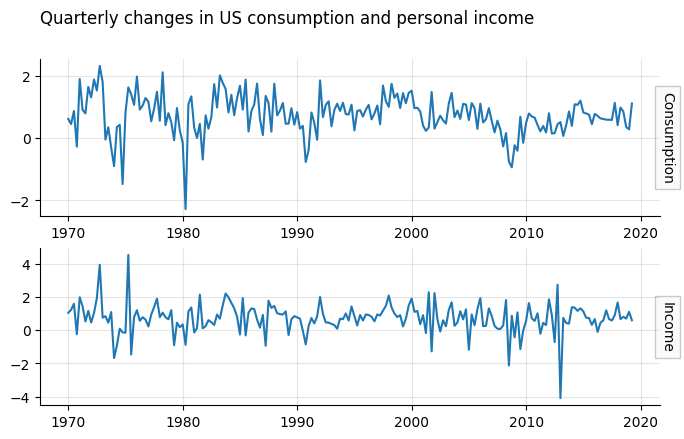

In [3]:
fig, axs = plt.subplots(2)
axs[0].plot(us_change.Consumption)
rlabel(axs[0], 'Consumption')
axs[1].plot(us_change.Income)
rlabel(axs[1], 'Income')
suptitle('Quarterly changes in US consumption and personal income')
for ax in axs:
    ax.grid()

In [4]:
split = us_change.index.max() + pd.to_timedelta('1d')
d = extend_timeseries(us_change, 'today')
dtrain, dtest = d[:split], d[split:]

In [5]:
fit = sm.tsa.statespace.SARIMAX(dtrain.Consumption, dtrain.Income, order=(1,0,2), trend='c').fit()

In [6]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Mon, 20 Jul 2020   AIC                            338.072
Time:                        20:13:57   BIC                            357.802
Sample:                    01-01-1970   HQIC                           346.058
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1743      0.063      2.788      0.005       0.052       0.297
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7070      0.106      6.658      0.000       0.499       0.915
ma.L1         -0.6172      0.113     -5.468      0.000      -0.838      -0.396
ma.L2          0.2066      0.065      3.174      0.002       0.079       0.334
sigma2         0.3035      0.022     13.525      0.000       0.260       0.347
===================================================================================
Ljung-Box (Q):                       33.62   Jarque-Bera (JB):                45.83
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

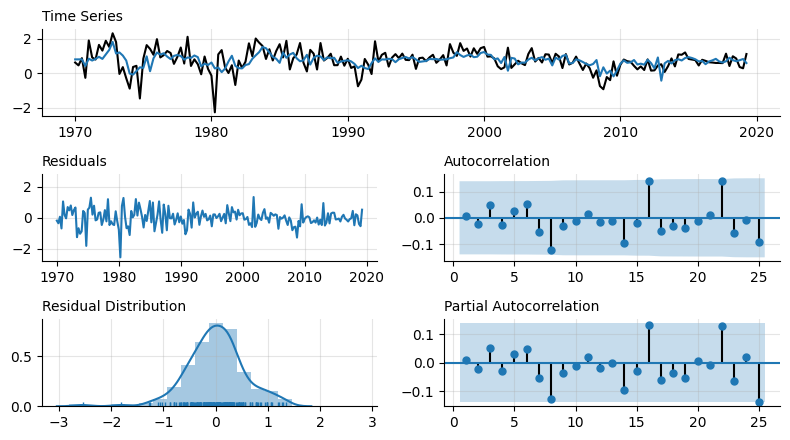

In [7]:
plot_tsresiduals(dtrain.Consumption, fit.fittedvalues);

In [8]:
sm.stats.acorr_ljungbox(
    dtrain.Consumption - fit.fittedvalues, lags=[8], model_df=5, boxpierce=True, return_df=True)

lb_stat  lb_pvalue   bp_stat  bp_pvalue
8  5.221391   0.156285  4.990544   0.172491

In [9]:
auto_arima_kw = dict(suppress_warnings=True, error_action='ignore', trace=True)

In [10]:
fit = pmd.auto_arima(dtrain.Consumption, dtrain[['Income']], **auto_arima_kw)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=338.516, BIC=361.534, Time=0.196 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=357.307, BIC=367.172, Time=0.043 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=353.625, BIC=366.778, Time=0.055 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=356.125, BIC=369.278, Time=0.063 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=437.987, BIC=444.564, Time=0.040 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=338.072, BIC=357.802, Time=0.130 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=346.555, BIC=362.997, Time=0.070 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=342.489, BIC=358.931, Time=0.108 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=339.377, BIC=362.395, Time=0.151 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=341.465, BIC=361.195, Time=0.082 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=339.637

In [11]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Mon, 20 Jul 2020   AIC                            338.072
Time:                        20:13:59   BIC                            357.802
Sample:                    01-01-1970   HQIC                           346.058
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1743      0.063      2.788      0.005       0.052       0.297
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7070      0.106      6.658      0.000       0.499       0.915
ma.L1         -0.6172      0.113     -5.468      0.000      -0.838      -0.396
ma.L2          0.2066      0.065      3.174      0.002       0.079       0.334
sigma2         0.3035      0.022     13.525      0.000       0.260       0.347
===================================================================================
Ljung-Box (Q):                       33.62   Jarque-Bera (JB):                45.83
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

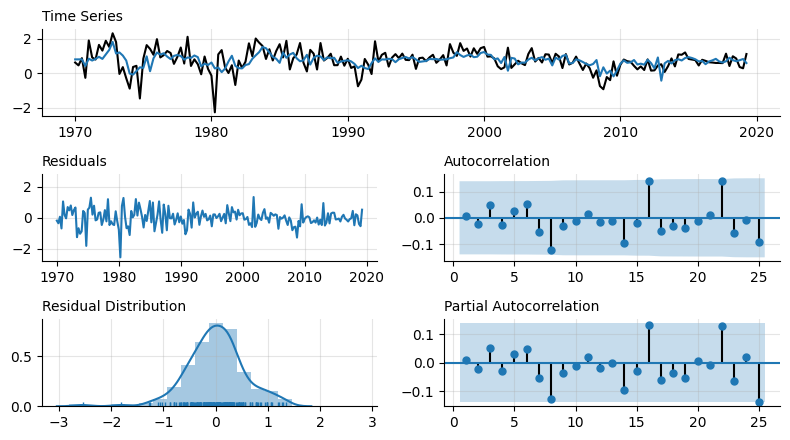

In [12]:
plot_tsresiduals(dtrain.Consumption, fit.arima_res_.fittedvalues);

## 10.3 Forecasting

[FPP3 Section 10.3](https://otexts.com/fpp3/forecasting.html)

### Example: US Personal Consumption and Income

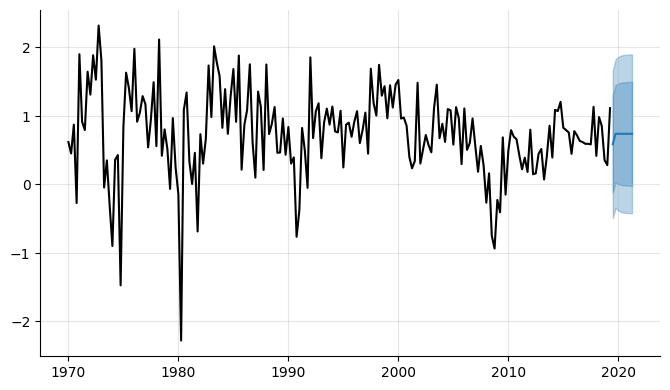

In [13]:
fig, ax = plt.subplots()
ax.plot(us_change.Consumption, 'k')

#ddtest = dtest.assign(Income = dtrain.Income.mean())
#fc = fit.get_forecast(len(ddtest), exog=dtrain.Income)
exog = np.repeat(dtrain.Income.mean(), 8)
fc = fit.arima_res_.get_forecast(len(exog), exog=exog)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ax.grid()

### Example: Forecasting electricity demand

**TODO:** doesn't this seem overly complicated?

In [14]:
vic_elec = (
    pd.read_csv('data/vic_elec.csv', parse_dates=['Time'], infer_datetime_format=True)
    .query('Time.dt.year == 2014')
    .set_index('Time', drop=False)
    .resample('1d')
    .agg(dict(Demand='sum', Temperature='mean', Holiday='any', Time='min'))
    .pipe(compute, lambda x: dict(
        Demand = x.Demand / 1e3,
        DayOfWeek = x.Time.dt.strftime('%A'),
    ))
    .pipe(compute, lambda x: dict(
        Day_Type = np.where(
            x.Holiday,
            'Holiday',
            np.where(
                x.DayOfWeek.isin(['Saturday', 'Sunday']),
                'Weekend',
                'Weekday'
            )
        )
    ))
    .pipe(compute, lambda x: dict(
        Is_Work_Day = x.Day_Type.eq('Weekend')
    ))
    .iloc[:-1] # last day is partial
)
vic_elec

Temperature  Holiday       Time      Demand  DayOfWeek Day_Type  \
Time                                                                          
2014-01-01    20.031250     True 2014-01-01  179.453794  Wednesday  Holiday   
2014-01-02    17.487500    False 2014-01-02  190.778816   Thursday  Weekday   
2014-01-03    17.718750    False 2014-01-03  182.892121     Friday  Weekday   
2014-01-04    16.575000    False 2014-01-04  171.285812   Saturday  Weekend   
2014-01-05    17.606250    False 2014-01-05  179.734300     Sunday  Weekend   
...                 ...      ...        ...         ...        ...      ...   
2014-12-26    16.429167     True 2014-12-26  168.797125     Friday  Holiday   
2014-12-27    18.189583    False 2014-12-27  173.292326   Saturday  Weekend   
2014-12-28    24.539583    False 2014-12-28  196.116229     Sunday  Weekend   
2014-12-29    17.677083    False 2014-12-29  188.570258     Monday  Weekday   
2014-12-30    17.391667    False 2014-12-30  187.212227    Tuesday  Weekday   

            Is_Work_Day  
Time                     
2014-01-01        False  
2014-01-02        False  
2014-01-03        False  
2014-01-04         True  
2014-01-05         True  
...                 ...  
2014-12-26        False  
2014-12-27         True  
2014-12-28         True  
2014-12-29        False  
2014-12-30        False  

[364 rows x 7 columns]

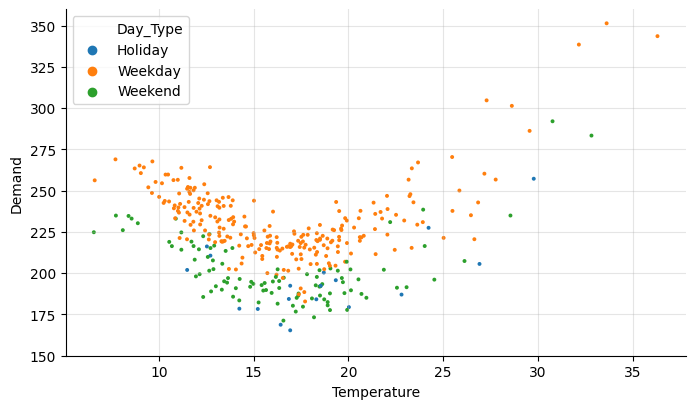

In [15]:
fig, ax = plt.subplots()
d = vic_elec
sns.scatterplot('Temperature', 'Demand', hue='Day_Type', data=d, ax=ax,
                linewidth=0, s=8)
ax.set(ylim=(150, 360))
ax.grid()

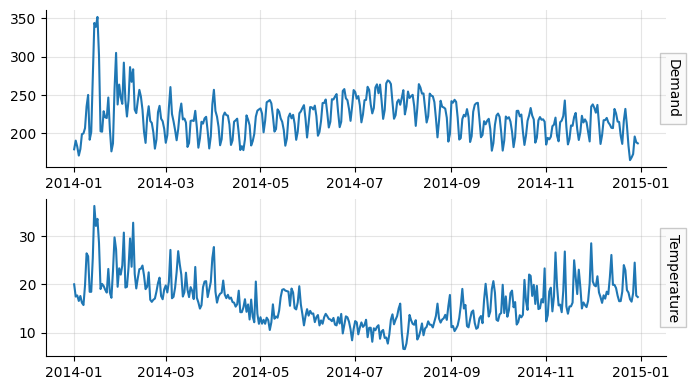

In [16]:
fig, axs = plt.subplots(2)
axs[0].plot(d.Demand)
rlabel(axs[0], 'Demand')
axs[1].plot(d.Temperature)
rlabel(axs[1], 'Temperature')
for ax in axs:
    ax.grid()

In [17]:
d = vic_elec.copy()
d['Temperature2'] = d.Temperature**2
split = d.index.max() + pd.to_timedelta('1h')
d = extend_timeseries(d, dt='28d')
d['Time'] = d.index
dtrain, dtest = d[:split], d[split:]

In [18]:
fit = pmd.auto_arima(
    dtrain.Demand,
    dtrain['Temperature Temperature2 Is_Work_Day'.split()].astype(float),
    **auto_arima_kw)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=2756.089, BIC=2791.139, Time=0.595 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2811.725, BIC=2831.197, Time=0.098 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2811.296, BIC=2834.663, Time=0.299 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2806.584, BIC=2829.951, Time=0.260 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2809.728, BIC=2825.305, Time=0.163 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=2760.327, BIC=2791.482, Time=0.496 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=2758.177, BIC=2789.332, Time=0.486 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=2762.223, BIC=2801.167, Time=0.545 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=2709.113, BIC=2748.057, Time=0.696 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=2761.832, BIC=2796.882, Time=0.672 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) [intercep

In [19]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1344.556
Date:                Mon, 20 Jul 2020   AIC                           2709.113
Time:                        20:14:08   BIC                           2748.057
Sample:                    01-01-2014   HQIC                          2724.593
                         - 12-30-2014                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0022      0.211      0.011      0.992      -0.411       0.416
Temperature    -11.0287      0.764    -14.439      0.000     -12.526      -9.532
Temperature2     0.3255      0.017     19.721      0.000       0.293       0.358
Is_Work_Day    -19.7228      1.424    -13.849      0.000     -22.514     -16.932
ar.L1            1.2401      0.004    289.073      0.000       1.232       1.248
ar.L2           -0.9984      0.003   -356.877      0.000      -1.004      -0.993
ma.L1           -1.6803      0.041    -40.991      0.000      -1.761      -1.600
ma.L2            1.5145      0.057     26.797      0.000       1.404       1.625
ma.L3           -0.4386      0.043    -10.302      0.000      -0.522      -0.355
sigma2          91.0868      4.037     22.561      0.000      83.174      99.000
===================================================================================
Ljung-Box (Q):                       63.61   Jarque-Bera (JB):               662.78
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

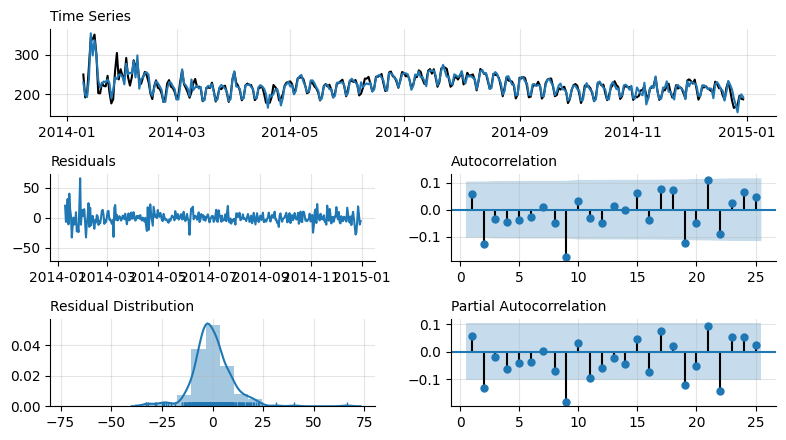

In [20]:
t0 = '2014-01-10'
plot_tsresiduals(dtrain[t0:].Demand, fit.arima_res_.fittedvalues[t0:]);

In [21]:
ddtest = dtest.assign(
    Temperature=26,
    Temperature2=26**2,
    Holiday=np.r_[False, True, np.repeat(False, len(dtest)-2)])
ddtest['Is_Work_Day'] = (
    (~ddtest.Holiday)
    & (~ddtest.Time.dt.day_name().isin(['Saturday', 'Sunday']))
)

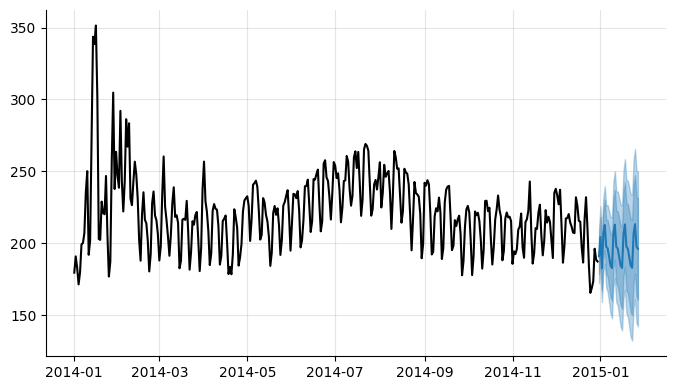

In [22]:
fig, ax = plt.subplots()
ax.plot(dtrain.Demand, 'k')

fc = fit.arima_res_.get_forecast(
    len(ddtest),
    exog=ddtest['Temperature Temperature2 Is_Work_Day'.split()].astype(float))
#exog = np.repeat(dtrain.Income.mean(), 8)
#fc = fit.get_forecast(len(exog), exog=exog)

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ax.grid()

We can also be a little more specific with our call to `pmdarima.auto_arima()`:

In [23]:
fit2 = pmd.auto_arima(
    dtrain.Demand,
    dtrain['Temperature Temperature2 Is_Work_Day'.split()].astype(float),
    start_P=1, start_Q=1,
    max_P=3, max_Q=3,
    d=0, D=1,
    start_p=1, start_q=1,
    max_p=3, max_q=3, m=7,
    seasonal=True,
    stepwise=True,
    **auto_arima_kw
)

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=2608.011, BIC=2642.911, Time=1.302 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=2893.426, BIC=2912.815, Time=0.094 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=2705.197, BIC=2732.341, Time=1.150 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=2743.925, BIC=2771.069, Time=1.069 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=2891.479, BIC=2906.990, Time=0.187 seconds
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=2603.964, BIC=2634.986, Time=1.197 seconds
Near non-invertible roots for order (1, 0, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(1,0,1)x(1,1,0,7) [intercept=True]; AIC=2704.727, BIC=2735.749, Time=1.507 seconds
Fit ARIMA(1,0,1)x(2,1,1,7) [intercept=True]; AIC=2606.363, BIC=2645.140, Time=2.512 seconds
Near non-invertible roots for order (1, 0, 1)(2, 1, 1, 7); set

In [24]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  364
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1293.982
Date:                           Mon, 20 Jul 2020   AIC                           2603.964
Time:                                   20:14:41   BIC                           2634.986
Sample:                               01-01-2014   HQIC                          2616.303
                                    - 12-30-2014                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0110      0.027     -0.412      0.680      -0.063       0.041
Temperature    -10.0542      0.685    -14.678      0.000     -11.397      -8.712
Temperature2     0.3001      0.015     19.651      0.000       0.270       0.330
Is_Work_Day     19.8519      2.822      7.036      0.000      14.322      25.382
ar.L1            0.9011      0.028     32.464      0.000       0.847       0.956
ma.L1           -0.2954      0.053     -5.538      0.000      -0.400      -0.191
ma.S.L7         -0.9881      0.093    -10.582      0.000      -1.171      -0.805
sigma2          76.8141      7.242     10.606      0.000      62.620      91.009
===================================================================================
Ljung-Box (Q):                       52.59   Jarque-Bera (JB):              1092.74
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
ddtest = dtest.assign(
    Temperature=26,
    Temperature2=26**2,
    Holiday=np.r_[False, True, np.repeat(False, len(dtest)-2)])
ddtest['Is_Work_Day'] = (
    (~ddtest.Holiday)
    & (~ddtest.Time.dt.day_name().isin(['Saturday', 'Sunday']))
)

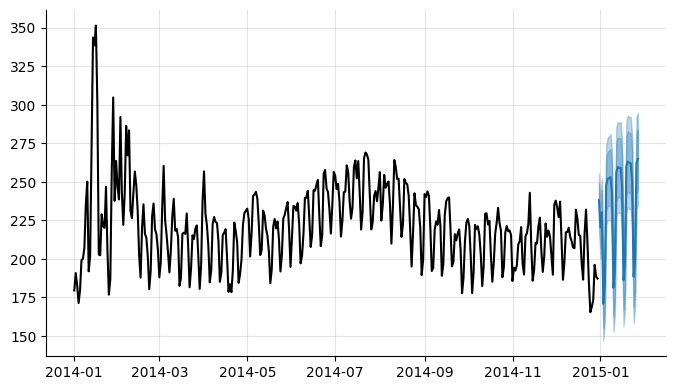

In [26]:
fig, ax = plt.subplots()
ax.plot(dtrain.Demand, 'k')

fc = fit2.arima_res_.get_forecast(
    len(ddtest),
    exog=ddtest['Temperature Temperature2 Is_Work_Day'.split()].astype(float))
#exog = np.repeat(dtrain.Income.mean(), 8)
#fc = fit.get_forecast(len(exog), exog=exog)

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ax.grid()

## 10.4 Stochastic and deterministic trends

[FPP3 Section 10.4](https://otexts.com/fpp3/stochastic-and-deterministic-trends.html)

### Example: International visitors to Australia

In [27]:
aus_visitors = rdatasets.data('fpp2', 'austa')
aus_visitors = (
    aus_visitors
    .set_index(pd.to_datetime(aus_visitors.time, format='%Y'))
    .pipe(set_freq)
)

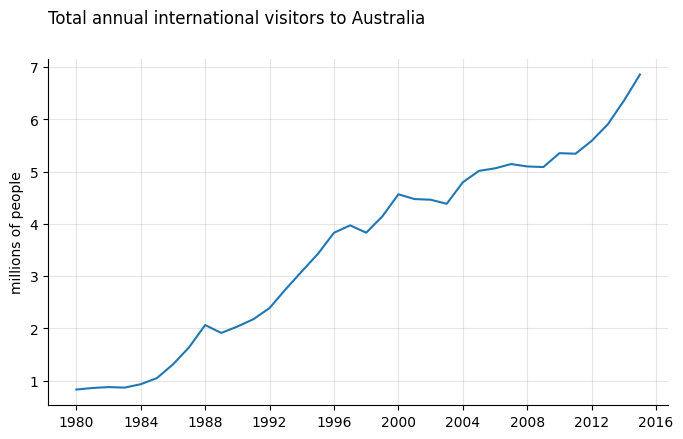

In [28]:
fig, ax = plt.subplots()
ax.plot(aus_visitors.value)
ax.set(ylabel='millions of people')
suptitle('Total annual international visitors to Australia')
ax.grid()

In [29]:
fit = sm.tsa.SARIMAX(aus_visitors.value, trend='ct', order=(2,0,0)).fit()

/Users/mrichman/ve/main/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [30]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   36
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  14.225
Date:                Mon, 20 Jul 2020   AIC                            -18.451
Time:                        20:14:42   BIC                            -10.533
Sample:                    01-01-1980   HQIC                           -15.687
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1850      0.109      1.700      0.089      -0.028       0.398
drift          0.0475      0.020      2.320      0.020       0.007       0.088
ar.L1          1.0962      0.166      6.603      0.000       0.771       1.422
ar.L2         -0.3651      0.163     -2.239      0.025      -0.685      -0.046
sigma2         0.0256      0.008      3.167      0.002       0.010       0.041
===================================================================================
Ljung-Box (Q):                       15.38   Jarque-Bera (JB):                 0.05
Prob(Q):                              1.00   Prob(JB):                         0.97
Heteroskedasticity (H):               1.67   Skew:                            -0.02
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
fit2 = sm.tsa.SARIMAX(aus_visitors.value, trend='c', order=(2,1,0)).fit()

In [32]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   36
Model:               SARIMAX(2, 1, 0)   Log Likelihood                  10.710
Date:                Mon, 20 Jul 2020   AIC                            -13.419
Time:                        20:14:42   BIC                             -7.198
Sample:                    01-01-1980   HQIC                           -11.272
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1461      0.050      2.915      0.004       0.048       0.244
ar.L1          0.2910      0.194      1.501      0.133      -0.089       0.671
ar.L2         -0.1373      0.224     -0.613      0.540      -0.576       0.302
sigma2         0.0317      0.012      2.720      0.007       0.009       0.054
===================================================================================
Ljung-Box (Q):                       27.96   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.76   Prob(JB):                         0.44
Heteroskedasticity (H):               1.34   Skew:                            -0.22
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

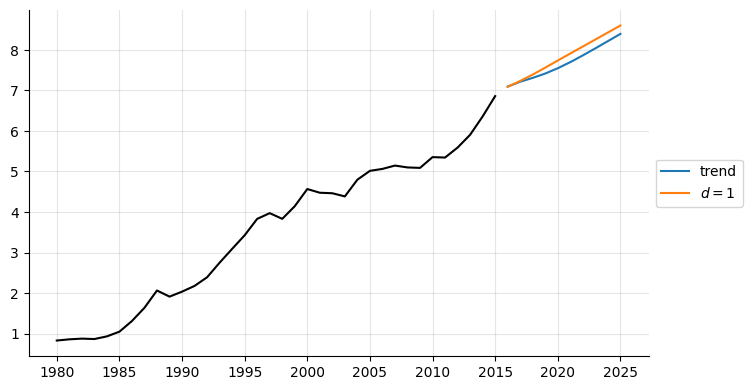

In [33]:
fig, ax = plt.subplots()
ax.plot(aus_visitors.value, 'k')

fc = fit.get_forecast(10)
ax.plot(fc.predicted_mean, label='trend')

fc = fit2.get_forecast(10)
ax.plot(fc.predicted_mean, label='$d=1$')

ax.legend(**legend_right)

ax.grid()

## 10.5 Dynamic harmonic regression

[FPP3 Section 10.5](https://otexts.com/fpp3/dhr.html)

In [34]:
aus_cafe = (
    pd.read_csv('data/aus_retail.csv', parse_dates=['Month'], infer_datetime_format=True)
    .query('Industry.str.contains("takeaway")')
    .query('Month.dt.year.between(2004, 2018)')
    .groupby('Month').Turnover.sum()
    .pipe(set_freq)
)

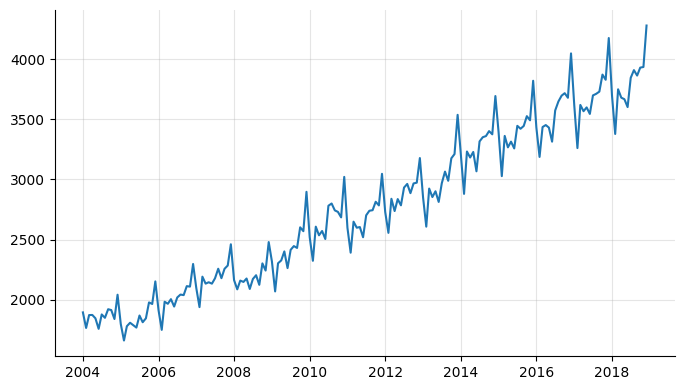

In [35]:
fig, ax = plt.subplots()
ax.plot(aus_cafe)
ax.grid()

In [36]:
fits = {
    k: sm.tsa.UnobservedComponents(
        aus_cafe,
        level=True, trend=True,
        freq_seasonal=[{'period':12,'harmonics':k}]).fit()
    for k in range(1, 7)
}

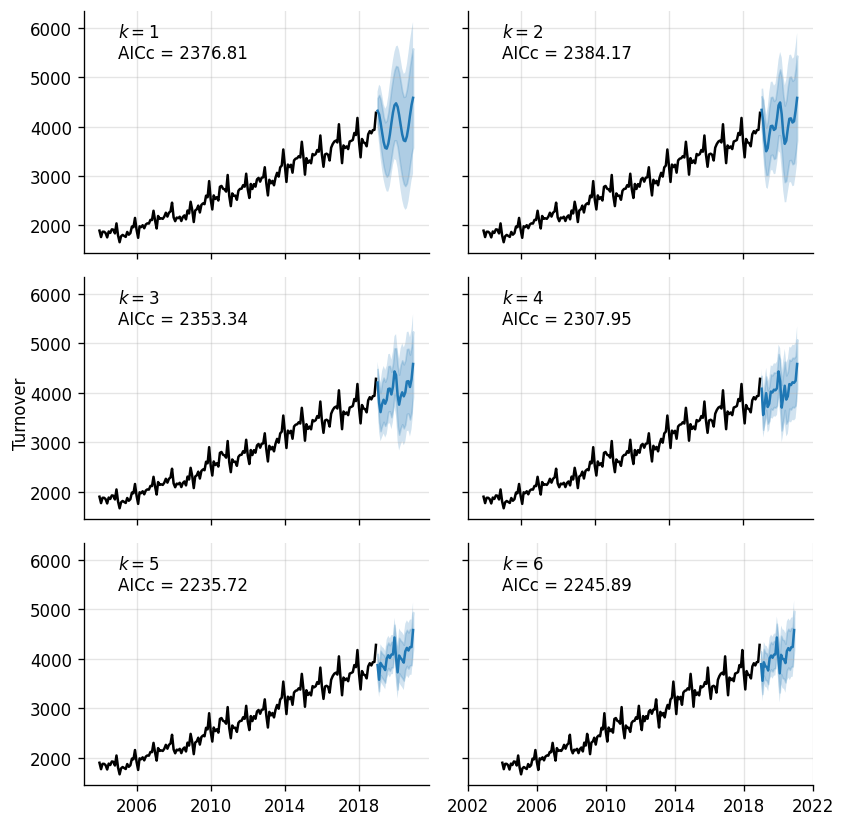

In [37]:
fig, axs = plt.subplots(3, 2, figsize=(7,7), sharex=True, sharey=True, dpi=120)
axs = axs.ravel()
for (ax,(k,fit)) in zip(axs, fits.items()):
    ax.plot(aus_cafe, 'k')
    fc = fit.get_forecast(24)
    ax.plot(fc.predicted_mean)
    ci = ciclean(fc.conf_int())
    ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.2)
    ci = ciclean(fc.conf_int(alpha=.2))
    ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.2, color='C0')
    ax.grid()
    xdate(ax, '%Y', '4ys')
    ax.text(.1, .95, f'$k={k}$\nAICc = {fit.aicc:.2f}', va='top', transform=ax.transAxes)
fig.text(0, .5, 'Turnover', rotation=90, va='center')
plt.tight_layout()

## 10.6 Lagged predictors

[FPP3 Section 10.6](https://otexts.com/fpp3/lagged-predictors.html)

### Example: TV advertising and insurance quotations

In [38]:
d = rdatasets.data('fpp2', 'insurance')
d.columns = 'Quotes', 'TV_advert'
d = d.set_index(pd.date_range('2002-01-01', '2005-04-01', freq='MS'))
d = extend_timeseries(d, dt='1y')
for lag in range(4):
    d[f'advert_{lag}'] = d.TV_advert.shift(lag)
insurance = d = d.dropna()

In [39]:
d.tail(15)

Quotes  TV_advert   advert_0   advert_1   advert_2  advert_3
2004-02-01  13.63092   9.565460   9.565460   8.010201   6.977100  6.939995
2004-03-01   9.12098   6.272510   6.272510   9.565460   8.010201  6.977100
2004-04-01   8.39468   5.707495   5.707495   6.272510   9.565460  8.010201
2004-05-01  12.30076   7.963540   7.963540   5.707495   6.272510  9.565460
2004-06-01  13.84831   8.494221   8.494221   7.963540   5.707495  6.272510
2004-07-01  15.96246   9.789085   9.789085   8.494221   7.963540  5.707495
2004-08-01  14.19738   8.692825   8.692825   9.789085   8.494221  7.963540
2004-09-01  12.85922   8.057230   8.057230   8.692825   9.789085  8.494221
2004-10-01  12.08837   7.588995   7.588995   8.057230   8.692825  9.789085
2004-11-01  12.93375   8.244881   8.244881   7.588995   8.057230  8.692825
2004-12-01  11.72235   6.675540   6.675540   8.244881   7.588995  8.057230
2005-01-01  15.47126   9.219604   9.219604   6.675540   8.244881  7.588995
2005-02-01  18.43898  10.963800  10.963800   9.219604   6.675540  8.244881
2005-03-01  17.49186  10.456290  10.456290  10.963800   9.219604  6.675540
2005-04-01  14.49168   8.728600   8.728600  10.456290  10.963800  9.219604

In [40]:
dtrain = d.iloc[:32]
dtest = d.iloc[32:]

In [41]:
%%time
lag0 = pmd.auto_arima(
    dtrain.Quotes, dtrain['advert_0'.split()],
    d=0, suppress_warnings=True)
lag1 = pmd.auto_arima(
    dtrain.Quotes, dtrain['advert_0 advert_1'.split()],
    d=0, suppress_warnings=True)
lag2 = pmd.auto_arima(
    dtrain.Quotes, dtrain['advert_0 advert_1 advert_2'.split()],
    d=0, suppress_warnings=True)
lag3 = pmd.auto_arima(
    dtrain.Quotes, dtrain['advert_0 advert_1 advert_2 advert_3'.split()],
    d=0, suppress_warnings=True)

CPU times: user 9.25 s, sys: 947 ms, total: 10.2 s
Wall time: 4.01 s


In [42]:
lags = lag0, lag1, lag2, lag3
lags

(ARIMA(order=(1, 0, 1), suppress_warnings=True),
 ARIMA(order=(1, 0, 1), suppress_warnings=True),
 ARIMA(order=(1, 0, 1), suppress_warnings=True),
 ARIMA(order=(1, 0, 1), suppress_warnings=True))

In [43]:
pd.DataFrame([dict(aic=l.aic(), aicc=l.aicc(), bic=l.bic(), fit=l) for l in (lags)])

aic       aicc        bic  \
0  59.052931  61.360623  66.381610   
1  54.313028  57.673028  63.107444   
2  55.468753  60.135420  65.728904   
3  56.819785  63.080654  68.545672   

                                              fit  
0  ARIMA(order=(1, 0, 1), suppress_warnings=True)  
1  ARIMA(order=(1, 0, 1), suppress_warnings=True)  
2  ARIMA(order=(1, 0, 1), suppress_warnings=True)  
3  ARIMA(order=(1, 0, 1), suppress_warnings=True)

In [44]:
fit = lag1.arima_res_
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -21.157
Date:                Mon, 20 Jul 2020   AIC                             54.313
Time:                        20:14:52   BIC                             63.107
Sample:                    04-01-2002   HQIC                            57.228
                         - 11-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3206      0.439      0.731      0.465      -0.539       1.180
advert_0       1.3069      0.103     12.693      0.000       1.105       1.509
advert_1       0.2060      0.107      1.925      0.054      -0.004       0.416
ar.L1          0.7326      0.182      4.025      0.000       0.376       1.089
ma.L1          0.5879      0.222      2.648      0.008       0.153       1.023
sigma2         0.2069      0.066      3.118      0.002       0.077       0.337
===================================================================================
Ljung-Box (Q):                       17.96   Jarque-Bera (JB):                 7.39
Prob(Q):                              0.97   Prob(JB):                         0.02
Heteroskedasticity (H):               2.80   Skew:                            -1.00
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

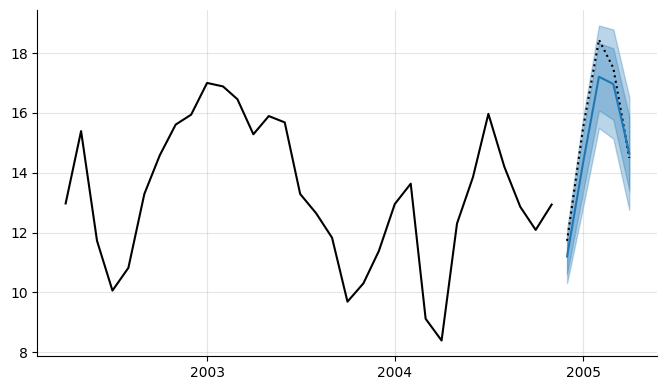

In [45]:
fig, ax = plt.subplots()
ax.plot(dtrain.Quotes, 'k')
ax.plot(dtest.Quotes, 'k:')

fc = fit.get_forecast(
    len(dtest), exog=dtest['advert_0 advert_1'.split()])

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')

xdate(ax, '%Y', '1ys')
ax.grid()

Or, as done in the book, assume advertising <- 8:

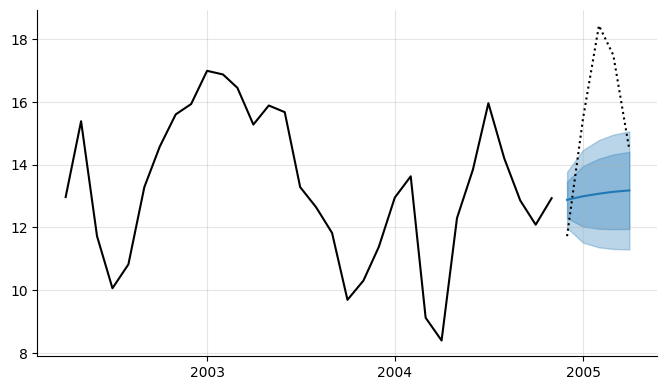

In [46]:
fig, ax = plt.subplots()
ax.plot(dtrain.Quotes, 'k')
ax.plot(dtest.Quotes, 'k:')

fc = fit.get_forecast(
    len(dtest), exog=dtest.assign(advert_0=8, advert_1=8)['advert_0 advert_1'.split()])

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')

xdate(ax, '%Y', '1ys')
ax.grid()

And... well, I guess that's that!

<hr/>

[Previous: ARIMA-models](09-ARIMA-models.ipynb)
• [Contents](Contents.ipynb)